In [314]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import missingno as msno

from tqdm import tqdm_notebook as tqdm 

from glob import glob
import os, random, time, gc, warnings 
    
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from catboost import CatBoostClassifier


from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 1. Data Laod 

In [315]:
#주최 측이 제공한 데이터셋 확인 
glob('../input/titanic/*.*')

['../input/titanic/train.csv',
 '../input/titanic/test.csv',
 '../input/titanic/gender_submission.csv']

In [316]:
# Data Load 
def load_dataset(path) : 
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    sample_submission = pd.read_csv(path + 'gender_submission.csv')
    return train, test, sample_submission

path = '../input/titanic/'
%time train, test, sample_submission = load_dataset(path)

CPU times: user 14.3 ms, sys: 2.56 ms, total: 16.9 ms
Wall time: 19.5 ms


## 2. Data Explore

In [317]:
#test set = no 'Survived'(=target col)
#train/test split by 'PassengerId' 
display(train.head(3))
display(test.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [318]:
print('-- Size --')
print(f'Train-set : {train.shape}')
print(f'Test-set : {test.shape}')

-- Size --
Train-set : (891, 12)
Test-set : (418, 11)


In [319]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [320]:
#columns only in Train-set
train.columns.difference(test.columns)

Index(['Survived'], dtype='object')

## 3.Understanding How Train/ Test split 

In [321]:
print('Mins/Max of PassengerId in Train-Set')
display(train.PassengerId.agg(['min', 'max']))
print('='*80)
print(len(train))
print()
print('Mins/Max of PassengerId in Test-Set')
display(test.PassengerId.agg(['min', 'max']))
print('='*80)
print(len(test))

#PassengerId ? .. No meaning. So should be removed when modeling 

Mins/Max of PassengerId in Train-Set


min      1
max    891
Name: PassengerId, dtype: int64

891

Mins/Max of PassengerId in Test-Set


min     892
max    1309
Name: PassengerId, dtype: int64

418


In [322]:
#distribution of features in each set 
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 4. Compare Train vs. Test

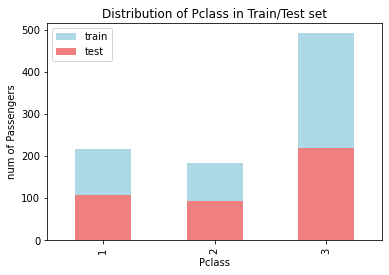

In [323]:
#Pclass : almost same proportion 
train['Pclass'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Pclass'].value_counts().sort_index().plot(kind='bar', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Pclass')
plt.ylabel('num of Passengers')
plt.title('Distribution of Pclass in Train/Test set')

plt.show()

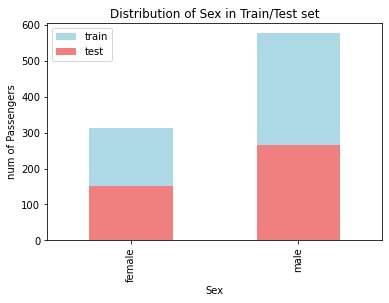

In [324]:
train['Sex'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Sex'].value_counts().sort_index().plot(kind='bar', color='lightcoral', label='test')

plt.legend()
plt.xlabel('Sex')
plt.ylabel('num of Passengers')
plt.title('Distribution of Sex in Train/Test set')

plt.show()

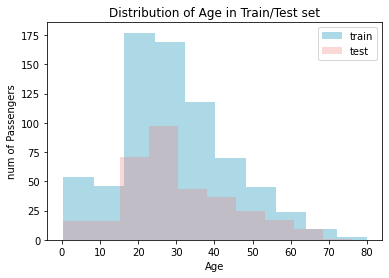

In [325]:
#Age : similar distribution 
train['Age'].plot(kind='hist', color='lightblue', label='train')
test['Age'].plot(kind='hist', color='lightcoral', alpha=0.3, label='test')

plt.legend()
plt.xlabel('Age')
plt.ylabel('num of Passengers')
plt.title('Distribution of Age in Train/Test set')

plt.show()

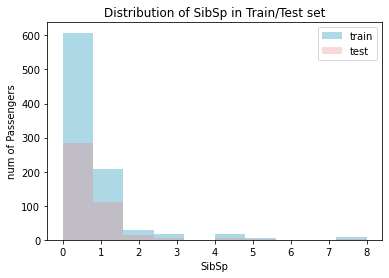

In [326]:
#Sibsp : similar distribution 
train['SibSp'].plot(kind='hist', color='lightblue', label='train')
test['SibSp'].plot(kind='hist', color='lightcoral', alpha=0.3, label='test')

plt.legend()
plt.xlabel('SibSp')
plt.ylabel('num of Passengers')
plt.title('Distribution of SibSp in Train/Test set')

plt.show()

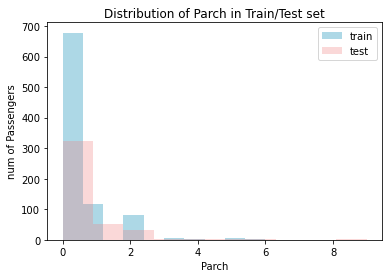

In [327]:
#Parch : similar distribution 
train['Parch'].plot(kind='hist', color='lightblue', label='train')
test['Parch'].plot(kind='hist', color='lightcoral', alpha = 0.3, label='test')

plt.legend()
plt.xlabel('Parch')
plt.ylabel('num of Passengers')
plt.title('Distribution of Parch in Train/Test set')

plt.show()

In [328]:
display(train['Parch'].value_counts()/len(train['Parch']))
display(test['Parch'].value_counts()/len(test['Parch']))

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64

0    0.775120
1    0.124402
2    0.078947
3    0.007177
9    0.004785
4    0.004785
6    0.002392
5    0.002392
Name: Parch, dtype: float64

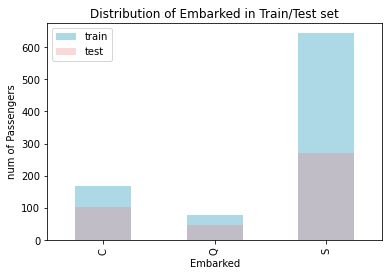

In [329]:
#Embarked : almost same proportion 
train['Embarked'].value_counts().sort_index().plot(kind='bar', color='lightblue', label='train')
test['Embarked'].value_counts().sort_index().plot(kind='bar', color='lightcoral', alpha=0.3, label='test')

plt.legend()
plt.xlabel('Embarked')
plt.ylabel('num of Passengers')
plt.title('Distribution of Embarked in Train/Test set')

plt.show()

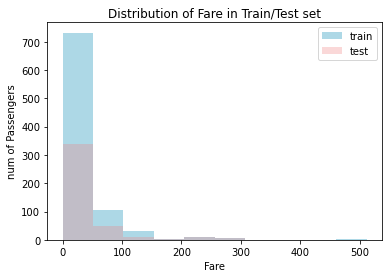

In [330]:
#Fare : similar distribution 
train['Fare'].plot(kind='hist', color='lightblue', label='train')
test['Fare'].plot(kind='hist', color='lightcoral', alpha=0.3, label='test')

plt.legend()
plt.xlabel('Fare')
plt.ylabel('num of Passengers')
plt.title('Distribution of Fare in Train/Test set')

plt.show()

#Fare= 0인 경우가 존재.... 어떤 경우인지 확인 필요함 


In [331]:
# Cabin .. Cabin has too many values so let it be explored later. 

## 5. Missing Values  
- Age, Cabin 

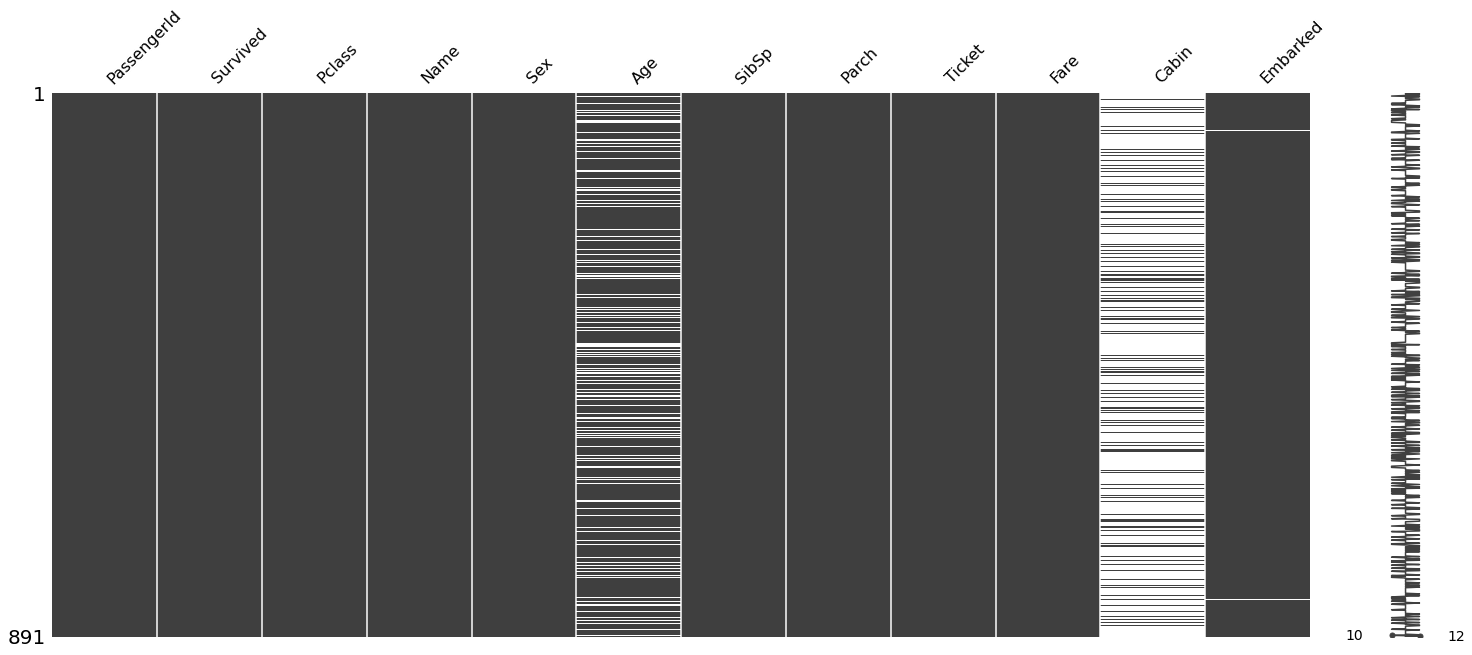

In [332]:
msno.matrix(train)

In [333]:
print('Train Set')
display(train.isnull().sum())
print('='*80)
print('Test Set')
display(test.isnull().sum())

Train Set


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Set


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 5.1. Dealing with missing values in 'Age'
* Age 결측치를 가진 탑승자 정보 확인
* 비슷한 정보를 가진 사람들의 평균 나이 확인하여 결측치 채우기

In [334]:
df_all=pd.concat([train, test])

pd.set_option('display.max_rows', 50)
df_all.Age.fillna(0, inplace=True)
print('Train/Test set - values in [Age]')
df_all.Age.value_counts()

# total 263 missing values 

Train/Test set - values in [Age]


0.00     263
24.00     47
22.00     43
21.00     41
30.00     40
        ... 
22.50      1
74.00      1
24.50      1
80.00      1
0.67       1
Name: Age, Length: 99, dtype: int64

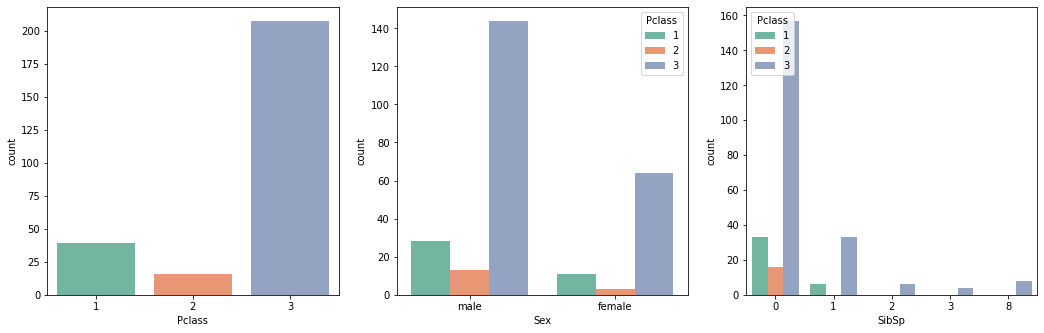

In [335]:
# Dataframe with Missing values of Age 
df_miss_age=df_all[df_all['Age']==0]

fig=plt.figure(figsize=(10,5))

ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=1.5, top=0.9, wspace=0.2, hspace=0.35)

sns.countplot(x='Pclass', palette='Set2', data=df_miss_age, ax=ax1)
sns.countplot(x='Sex', palette='Set2', data=df_miss_age, ax=ax2, hue='Pclass')
sns.countplot(x='SibSp', palette='Set2', data=df_miss_age, ax=ax3, hue='Pclass')

plt.show()


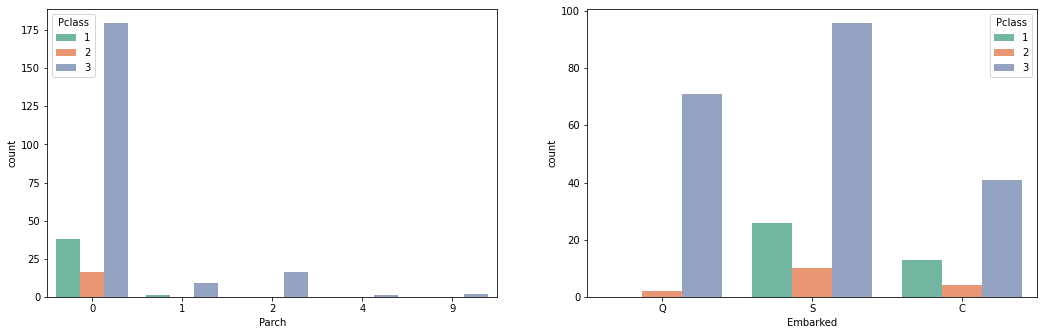

In [336]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=1.5, top=0.9, wspace=0.2, hspace=0.35)

sns.countplot(x='Parch', palette='Set2', data=df_miss_age, ax=ax1, hue='Pclass')
sns.countplot(x='Embarked', palette='Set2', data=df_miss_age, ax=ax2, hue='Pclass')

plt.show()

# 나이가 기재되지 않은 승객들은 Pclass에서 두드러진 차이를 보이고 있으므로 나이는 Pclass(+성별?)의 평균? 중앙값?으로 채워주기로 한다. 

In [337]:
display(df_all.groupby(['Sex','Pclass'])['Age'].agg('mean'))
print('='*80)
display(df_all.groupby(['Sex','Pclass'])['Age'].agg('median'))

#평균과 중앙값이 크게 차이나지 않기에 그냥 중앙값으로 채워주기로 한다.

Sex     Pclass
female  1         34.208333
        2         26.720943
        3         15.611898
male    1         34.611285
        2         28.472690
        3         18.378966
Name: Age, dtype: float64

Sex     Pclass
female  1         35.0
        2         27.0
        3         17.0
male    1         37.0
        2         28.0
        3         21.0
Name: Age, dtype: float64

In [338]:
df_all['Age'] = df_all['Age'].replace(0, np.nan)
df_all['Age']=df_all['Age'].fillna(df_all.groupby(['Sex', 'Pclass'])['Age'].transform('median'))

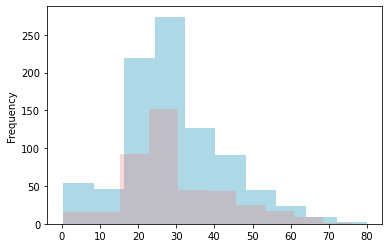

In [339]:
# train vs. test 
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

df_all_train['Age'].plot(kind='hist', color='lightblue', label='train')
df_all_test['Age'].plot(kind='hist', color='lightcoral', alpha=0.3, label='test')

### 5.2 Dealing with missing values in 'Cabin'

In [340]:
miss = df_all.Cabin[df_all['Pclass']==1].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==1].notnull().sum(axis=0)
print(f'Pclass=1 .. missing values : {miss},  existing values : {notmiss}')
print('='*80)

miss = df_all.Cabin[df_all['Pclass']==2].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==2].notnull().sum(axis=0)
print(f'Pclass=2 .. missing values : {miss},  existing values : {notmiss}')
print('='*80)

miss = df_all.Cabin[df_all['Pclass']==3].isnull().sum(axis=0)
notmiss=df_all.Cabin[df_all['Pclass']==3].notnull().sum(axis=0)
print(f'Pclass=3 .. missing values : {miss},  existing values : {notmiss}')

#주로 Pclass=1에서 Cabin values가 존재하는 것으로 보아, Cabin은 Pclass=1의 생존율 예측에 유의미한 영향을 미칠것이라 추론됨  

Pclass=1 .. missing values : 67,  existing values : 256
Pclass=2 .. missing values : 254,  existing values : 23
Pclass=3 .. missing values : 693,  existing values : 16


In [341]:
df_all['Cabin'].fillna('X', inplace=True)
df_all['Ca']=df_all['Cabin'].str[:1]
# Cabin의 알파벳과 숫자를 분리해서 알파벳+n번대로 만들어주고 이를 따로 분리  알파벳 -> [Ca]
# NaN값은 임의의 알파펫 X값으로 분리해줌 

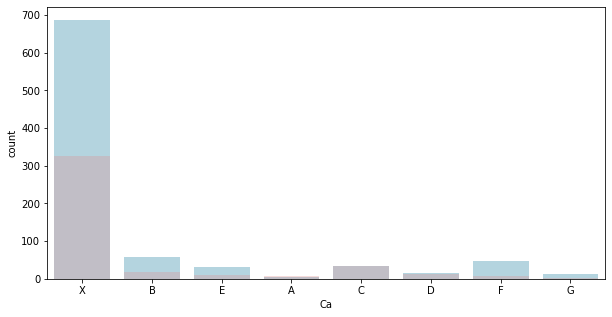

In [342]:
#compare train vs. test 
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

fig=plt.figure(figsize=(10,5))
sns.countplot(x=df_all_train['Ca'], color='lightblue', label='train')
sns.countplot(x=df_all_test['Ca'], color='lightcoral', alpha=0.3, label='test')
plt.show();

#F, G를 거의 학습하지 못할 것 같아서 확인을 해봐야겠다. 

In [343]:
df_all[(df_all['Ca']=='F') | (df_all['Ca']=='G')]
#G.. Cabin number가 G6로 같다. 따라서 괜찮을것같음. 
#F .. F를 보아하니.. Cabin num의 알파벳 뿐만 아니라 숫자도 중요할 것 같다.. 같은 객실=같은 가족인지 여부가 중요할 것 같음. 
# 같은 객실에 묵었는지 여부는 Cabin 말고도 Ticket으로 볼 수도 있다. 
# 티켓을 labeling 해볼까.. 싶기도 함. 그건 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,G
66,67,1.0,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S,F
75,76,0.0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S,F
128,129,1.0,3,"Peter, Miss. Anna",female,22.0,1,1,2668,22.3583,F E69,C,F
148,149,0.0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S,F
183,184,1.0,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S,F
193,194,1.0,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S,F
205,206,0.0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,G
251,252,0.0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,G
340,341,1.0,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S,F


In [344]:
df_all[df_all['Ca']=='X']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,X
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,X
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,X
5,6,0.0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,X,Q,X
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,X,S,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,X,S,X
413,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,X,S,X
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,X,S,X
416,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,X,S,X


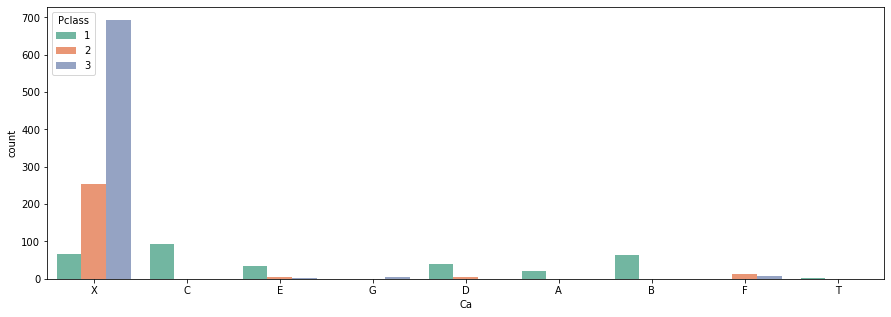

In [345]:
fig = plt.figure(figsize=(15,5))
sns.countplot(x=df_all['Ca'], palette='Set2', hue=df_all['Pclass'])
plt.show()


# A,B,C,T : pclass=1인 사람들만
# F : Pclass=3
# D : pclass=2
# E,G : Pclass 2, 3
# X : pclass=1,2,3

# 위의 알파벳은 숫자 편차가 심하므로 Ca을 다시 5개의 카테코리(1,2,3,4,5)로 분류하자. 

In [346]:
for ca in tqdm(df_all['Ca']) : 
    if ca=='A' or ca=='B' or ca=='C' or ca=='T' :
        df_all['Ca'].replace(ca, 1, inplace=True)
    elif ca=='E' or ca=='G' :
        df_all['Ca'].replace(ca, 2, inplace=True)
    elif ca=='D' :
        df_all['Ca'].replace(ca, 3, inplace=True) 
    elif ca=='F' :
        df_all['Ca'].replace(ca, 4, inplace=True)
    elif ca=='X' :
        df_all['Ca'].replace(ca, 5, inplace=True)
        
#문자형 타입으로 
df_all.Ca.astype(str)

0      5
1      1
2      5
3      1
4      5
      ..
413    5
414    1
415    5
416    5
417    5
Name: Ca, Length: 1309, dtype: object

In [347]:
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,5


### 5.3 filling the missing values - Embarked
There are two missing values on Embared, and referring to the notebook("https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial), fill the values with 'S'

In [348]:
df_all['Embarked']=df_all['Embarked'].fillna('S')

### 5.4 missing value - Fare

In [349]:
df_all[df_all['Fare'].isnull()]
# though there is one null in 'Fare', I don't think Fare is importand predictor.
# So I would just drop the column Fare later. 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,X,S,5


## 6 Testing Baseline Models

In [350]:
#Baseline models를 평가하기 위해 train, test데이터 분류. 
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

#Cross validation을 위해 train -> local_train, local_test로 분류
local_train = df_all_train[df_all_train.PassengerId<=800]
local_test = df_all_train[df_all_train.PassengerId >800]

In [351]:
display(local_train.Survived.value_counts()/len(local_train.Survived))
print('='*80)
display(local_test.Survived.value_counts()/len(local_test.Survived))
# 비슷한 비율로 잘 나눠진듯. 

0.0    0.615
1.0    0.385
Name: Survived, dtype: float64

0.0    0.626374
1.0    0.373626
Name: Survived, dtype: float64

In [352]:
#null 값 없음. 
display(df_all_train.info())
print('='*80)
display(df_all_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    float64
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Ca           891 non-null    int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 97.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
 11  Ca           418 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


None

In [353]:
# cols 
target_col='Survived'
cat_cols = ['Pclass', 'Sex','Embarked', 'Ca', target_col]  
drop_cols=['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare', target_col]

In [354]:
# Implement Label Encoding 
lbl = LabelEncoder()
for col in tqdm( cat_cols ):   
    temp_df=pd.concat([local_train[[col]], local_test[[col]]], axis=0)
    
    lbl.fit( temp_df[col] )
    local_train[col]=lbl.transform(local_train[col])
    local_test[col]=lbl.transform(local_test[col])

In [355]:
# Lightgbm pareameters : 
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'binary',   #목적 정의(평가함수) 
              'boosting': 'gbdt', #gradient boosting tree(가장 많이 쓰임))
              'random_state':1993,     #random_state, seed 파라미터 = 고정 
              'learning_rate':0.3,     #모델 학습을 얼마나 빨리? 0.3~0.5 정도? 데이터사이즈가 작으면 0.1? 
              'subsample':0.7,          #전체 데이터 중 몇%를 트레이닝에 사용?
              'tree_learner': 'serial',
              'colsample_bytree':0.78,   # 몇 개의 컬럼 사용? 컬럼 갯수가 겁나 많으면 과감하게 적게주는것도.. 
#               'early_stopping_rounds':10,  #모델 학습 진행 시 트레이닝 loss는 지속적 감소하는데, validation의 loss는 하락하지 않은 경우 50 iteration이 넘었을 때 학습을 중지 
              'subsample_freq': 1,
              'reg_lambda':7,    #reg_lambda, reg_alpha : 정규화 관련. 얼마나 많이 오버피팅을 방지하고 싶으냐. 보통은 1~3정도 넣음. 데이터가 많지 않을 때에는 높게 설정 
              'reg_alpha': 5,
              'num_leaves': 96,
              'metric' : 'auc',
              'seed' : SEED
            }

In [356]:
#local train, local test y(label) 정의 
local_train_label = local_train[target_col]
local_test_label = local_test[target_col]

In [357]:
# --------------- 1st : RandomForest
val_scores=[]
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=11)

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=local_train, y=local_train_label))):
    trn_data, trn_label = local_train.iloc[trn_idx].drop(drop_cols,1), local_train_label[trn_idx]
    val_data, val_label = local_train.iloc[val_idx].drop(drop_cols,1), local_train_label[val_idx]

    rf_model=RandomForestClassifier(
        n_estimators=1000,
        random_state=11,
        class_weight='balanced').fit(trn_data,trn_label)

#     valid_pred=model.predict(val_data)
#     test_pred = model.predict(local_test.drop(drop_cols,1))
    
    trn_acc = rf_model.score(trn_data, trn_label)
    val_acc = rf_model.score(val_data, val_label)


    print(f'========== {i} Fold ==========')
    print(f'train Accuracy : {trn_acc},  validation Accuracy ; {val_acc} ')
    print()    
          
    val_scores.append(val_acc)

print(f'Cross Validation Score : {np.mean(val_scores)}')

test_acc= rf_model.score(local_test.drop(drop_cols,1), local_test_label)
print(f'local_test Accuracy : {test_acc}')


========== 0 Fold ==========
train Accuracy : 0.9546875,  validation Accuracy ; 0.74375 

========== 1 Fold ==========
train Accuracy : 0.953125,  validation Accuracy ; 0.79375 

========== 2 Fold ==========
train Accuracy : 0.94375,  validation Accuracy ; 0.8 

========== 3 Fold ==========
train Accuracy : 0.9515625,  validation Accuracy ; 0.73125 

========== 4 Fold ==========
train Accuracy : 0.95,  validation Accuracy ; 0.8 


Cross Validation Score : 0.77375
local_test Accuracy : 0.8351648351648352


In [358]:
# --------------- 2nd : Lightgbm
val_scores=[]
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=11)

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=local_train, y=local_train_label))):
    trn_data, trn_label = local_train.iloc[trn_idx].drop(drop_cols,1), local_train_label[trn_idx]
    val_data, val_label = local_train.iloc[val_idx].drop(drop_cols,1), local_train_label[val_idx]
    
    model= lgbm.LGBMClassifier(**lgbm_param).fit(trn_data, trn_label)
    
    trn_acc = model.score(trn_data, trn_label)
    val_acc = model.score(val_data, val_label)


    print(f'========== {i} Fold ==========')
    print(f'train Accuracy : {trn_acc},  validation Accuracy ; {val_acc} ')
    print()    
          
    val_scores.append(val_acc)

print(f'Cross Validation Score : {np.mean(val_scores)}')

test_acc= model.score(local_test.drop(drop_cols,1), local_test_label)
print(f'local_test Accuracy : {test_acc}')


========== 0 Fold ==========
train Accuracy : 0.84375,  validation Accuracy ; 0.7625 

========== 1 Fold ==========
train Accuracy : 0.8234375,  validation Accuracy ; 0.84375 

========== 2 Fold ==========
train Accuracy : 0.8140625,  validation Accuracy ; 0.85 

========== 3 Fold ==========
train Accuracy : 0.8515625,  validation Accuracy ; 0.73125 

========== 4 Fold ==========
train Accuracy : 0.8171875,  validation Accuracy ; 0.80625 


Cross Validation Score : 0.79875
local_test Accuracy : 0.7802197802197802


In [359]:
# --------------- 3rd : XGBoost 

import xgboost as xgb

val_scores=list()

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=local_train, y=local_train_label))):
    trn_data, trn_label = local_train.iloc[trn_idx].drop(drop_cols,1), local_train_label[trn_idx]
    val_data, val_label = local_train.iloc[val_idx].drop(drop_cols,1), local_train_label[val_idx]

    xgb_model=xgb.XGBClassifier(
        n_estimators=1000,
        subsample=0.3,
        reg_alpha=10,
        random_state=11).fit(trn_data,trn_label)

    trn_acc = xgb_model.score(trn_data, trn_label)
    val_acc = xgb_model.score(val_data, val_label)
    
    print(f'========== {i} Fold ==========')
    print(f'train Accuracy : {trn_acc},  validation Accuracy ; {val_acc} ')
    print()
      
    val_scores.append(val_acc)


print(f'Cross Validation Score : {np.mean(val_scores)}')

test_acc= xgb_model.score(local_test.drop(drop_cols,1), local_test_label)
print(f'local_test Accuracy : {test_acc}')


========== 0 Fold ==========
train Accuracy : 0.8421875,  validation Accuracy ; 0.75625 

========== 1 Fold ==========
train Accuracy : 0.825,  validation Accuracy ; 0.85 

========== 2 Fold ==========
train Accuracy : 0.8171875,  validation Accuracy ; 0.88125 

========== 3 Fold ==========
train Accuracy : 0.840625,  validation Accuracy ; 0.7625 

========== 4 Fold ==========
train Accuracy : 0.828125,  validation Accuracy ; 0.825 


Cross Validation Score : 0.8150000000000001
local_test Accuracy : 0.8351648351648352


In [360]:
# --------------- 4th : Logistic 

val_scores=list()

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=local_train, y=local_train_label))):
    trn_data, trn_label = local_train.iloc[trn_idx].drop(drop_cols,1), local_train_label[trn_idx]
    val_data, val_label = local_train.iloc[val_idx].drop(drop_cols,1), local_train_label[val_idx]

    lg_model=LogisticRegression(
        solver ='liblinear',
#         class_weight='balanced',
        n_jobs=-1,
        random_state=11).fit(trn_data,trn_label)

    trn_acc = lg_model.score(trn_data, trn_label)
    val_acc = lg_model.score(val_data, val_label)
    
    print(f'========== {i} Fold ==========')
    print(f'train Accuracy : {trn_acc},  validation Accuracy ; {val_acc} ')
    print()
      
    val_scores.append(val_acc)


print(f'Cross Validation Score : {np.mean(val_scores)}')

test_acc= lg_model.score(local_test.drop(drop_cols,1), local_test_label)
print(f'local_test Accuracy : {test_acc}')


========== 0 Fold ==========
train Accuracy : 0.8234375,  validation Accuracy ; 0.75 

========== 1 Fold ==========
train Accuracy : 0.7984375,  validation Accuracy ; 0.825 

========== 2 Fold ==========
train Accuracy : 0.7859375,  validation Accuracy ; 0.8625 

========== 3 Fold ==========
train Accuracy : 0.83125,  validation Accuracy ; 0.74375 

========== 4 Fold ==========
train Accuracy : 0.7953125,  validation Accuracy ; 0.8375 


Cross Validation Score : 0.80375
local_test Accuracy : 0.8131868131868132


## 7. Feature Engineering - think of more features. 
- Fam_size  = Sib + Parch 
- Title  
- Sib and Parch : I think them important features since whether one was with parents(it means one=childs) and whether one was elder or younger did affect the survival rates

In [361]:
#Referring to many notebooks of others, create Fam_size and Title columns. 

df_all['Fam_size']=df_all['SibSp']+df_all['Parch']  #except oneself.  
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [362]:
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

In [363]:
df_all_train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Capt              1
Ms                1
Lady              1
Don               1
the Countess      1
Sir               1
Jonkheer          1
Mme               1
Name: Title, dtype: int64

In [364]:
df_all_test['Title'].value_counts()

#needs to narrow down  - Mr, Mrs, Miss
# Master, Major, Rev, Col, Dr, Jonkheer, Sir, Don, Capt -> Mr 
# Dona, Mme -> Mrs 
# Mlle, Ms, Lady -> Miss 

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64

In [365]:
for title in tqdm(df_all['Title']): 
    if title =='Master' or title =='Major' or title =='Rev' or title =='Col' or title =='Dr' or title =='Jonkheer' or title =='Sir' or \
    title =='Don' or title =='Capt' :
        df_all['Title'].replace(title, 'Mr', inplace=True)
    elif title =='Dona' or title =='Mme' or title=='the Countess' : 
        df_all['Title'].replace(title, 'Mrs', inplace=True)
    elif title =='Mlle' or title =='Ms' or title =='Lady': 
        df_all['Title'].replace(title, 'Miss', inplace=True)
        
df_all['Title'].value_counts()

Mr      844
Miss    265
Mrs     200
Name: Title, dtype: int64

In [366]:
# by_title = df_all.groupby(['SibSp', 'Parch','Title'])[['PassengerId']].count()

## 8.Testing Models 

In [367]:
#Baseline models를 평가하기 위해 train, test데이터 분류. 
df_all_train = df_all[df_all.PassengerId <=891]
df_all_test = df_all[df_all.PassengerId>891].drop('Survived', 1)

#Cross validation을 위해 train -> local_train, local_test로 분류
local_train = df_all_train[df_all_train.PassengerId<=800]
local_test = df_all_train[df_all_train.PassengerId >800]

In [368]:
df_all_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca,Fam_size,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,5,1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,5,0,Miss


In [369]:
#test set labeling 
#col 
cat_cols = ['Pclass', 'Sex','Embarked', 'Ca', 'Title']  
drop_cols=['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare']


lbl = LabelEncoder()
for col in tqdm( cat_cols ):   
    
    lbl.fit( df_all_test[col] )
    df_all_test[col]=lbl.transform(df_all_test[col])

In [370]:
# cols 
target_col='Survived'
cat_cols = ['Pclass', 'Sex','Embarked', 'Ca', target_col, 'Title']  
drop_cols=['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare', target_col]


# Implement Label Encoding 
lbl = LabelEncoder()
for col in tqdm( cat_cols ):   
    temp_df=pd.concat([local_train[[col]], local_test[[col]]], axis=0)
    
    lbl.fit( temp_df[col] )
    local_train[col]=lbl.transform(local_train[col])
    local_test[col]=lbl.transform(local_test[col])

In [371]:
#local train, local test y(label) 정의 
local_train_label = local_train[target_col]
local_test_label = local_test[target_col]

In [372]:
#params 
# Lightgbm  : 
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993
lgbm_param = {'objective':'binary',   #목적 정의(평가함수) 
              'boosting': 'gbdt', #gradient boosting tree(가장 많이 쓰임))
              'random_state':1993,     #random_state, seed 파라미터 = 고정 
              'learning_rate':0.3,     #모델 학습을 얼마나 빨리? 0.3~0.5 정도? 데이터사이즈가 작으면 0.1? 
              'subsample':0.7,          #전체 데이터 중 몇%를 트레이닝에 사용?
              'tree_learner': 'serial',
              'colsample_bytree':0.78,   # 몇 개의 컬럼 사용? 컬럼 갯수가 겁나 많으면 과감하게 적게주는것도.. 
#               'early_stopping_rounds':10,  #모델 학습 진행 시 트레이닝 loss는 지속적 감소하는데, validation의 loss는 하락하지 않은 경우 50 iteration이 넘었을 때 학습을 중지 
              'subsample_freq': 1,
              'reg_lambda':7,    #reg_lambda, reg_alpha : 정규화 관련. 얼마나 많이 오버피팅을 방지하고 싶으냐. 보통은 1~3정도 넣음. 데이터가 많지 않을 때에는 높게 설정 
              'reg_alpha': 5,
              'num_leaves': 96,
              'metric' : 'auc',
              'seed' : SEED
            }

# DecisionTree 
# dt_params = {
#             'criterion' : 'gini',
#             'max_depth' : 7, 
#             'min_samples_split' : 5,
#             'max_features' : 'log2',
#             }

# CatBoost 
n_rounds = 1000

cat_params = {
        'n_estimators': n_rounds,
        'learning_rate': 0.08,
        'eval_metric': 'Accuracy',
        'logging_level' : 'Silent',
        'loss_function': 'Logloss',
#         'random_seed': 42,
        'metric_period': 500,
        'od_wait': 500,
#         'task_type': 'GPU',
       'l2_leaf_reg' : 3,
        'depth': 8,
    }

In [373]:
# --------------- 2nd : Light gbm
lgbm_val_scores=[]
xgb_val_scores=[]
lg_val_scores=[]
cat_val_scores=[]

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=11)

for i , (trn_idx, val_idx) in tqdm(enumerate(cv.split(X=local_train, y=local_train_label))):
    trn_data, trn_label = local_train.iloc[trn_idx].drop(drop_cols,1), local_train_label[trn_idx]
    val_data, val_label = local_train.iloc[val_idx].drop(drop_cols,1), local_train_label[val_idx]

    print(f'========== {i} Fold ==========')
    print(f'TRAINING LGBM')
    # ------ Light gbm 
    model= lgbm.LGBMClassifier(**lgbm_param).fit(trn_data, trn_label)
        
    lgbm_trn_acc = model.score(trn_data, trn_label)
    lgbm_val_acc = model.score(val_data, val_label)
    
    print(f'TRAINING XGB')
    # ------ xgb 
    xgb_model=xgb.XGBClassifier(
        n_estimators=1000,
        subsample=0.3,
        reg_alpha=10,
        random_state=11).fit(trn_data,trn_label)

    xgb_trn_acc = xgb_model.score(trn_data, trn_label)
    xgb_val_acc = xgb_model.score(val_data, val_label)
    
    
    print(f'TRAINING LogisticRegression')
    # ------ Logistic  
    lg_model=LogisticRegression(
        solver ='liblinear',
#         class_weight='balanced',
        n_jobs=-1,
        random_state=11).fit(trn_data,trn_label)

    lg_trn_acc = lg_model.score(trn_data, trn_label)
    lg_val_acc = lg_model.score(val_data, val_label)


    print(f'TRAINING CatBoost')
    # ------ DT  
    cat_model=CatBoostClassifier(
        **cat_params,
        random_state=11).fit(trn_data,trn_label)

    cat_trn_acc = cat_model.score(trn_data, trn_label)
    cat_val_acc = cat_model.score(val_data, val_label) 


    lgbm_val_scores.append(lgbm_val_acc)
    xgb_val_scores.append(xgb_val_acc)
    lg_val_scores.append(lg_val_acc)
    cat_val_scores.append(cat_val_acc)


    
print(f'Cross Validation Score - Light GBM : {np.mean(lgbm_val_scores)}')
print(f'Cross Validation Score - XGB : {np.mean(xgb_val_scores)}')
print(f'Cross Validation Score - Logistic : {np.mean(lg_val_scores)}')
print(f'Cross Validation Score - CatBoost : {np.mean(cat_val_scores)}')
print('='*80)

lgbm_test_acc= model.score(local_test.drop(drop_cols,1), local_test_label)
xgb_test_acc= xgb_model.score(local_test.drop(drop_cols,1), local_test_label)
lg_test_acc= lg_model.score(local_test.drop(drop_cols,1), local_test_label)
cat_test_acc= cat_model.score(local_test.drop(drop_cols,1), local_test_label)

print(f'local_test Accuracy - Light GBM: {lgbm_test_acc}')
print(f'local_test Accuracy - XGB: {xgb_test_acc}')
print(f'local_test Accuracy - Logistic: {lg_test_acc}')
print(f'local_test Accuracy - CatBoost: {cat_test_acc}')

# local_test Accuracy - Light GBM: 0.8351648351648352
# local_test Accuracy - XGB: 0.8351648351648352
# local_test Accuracy - DT: 0.8241758241758241
# local_test Accuracy - CatBoost: 0.8241758241758241

========== 0 Fold ==========
TRAINING LGBM
TRAINING XGB
TRAINING LogisticRegression
TRAINING CatBoost
========== 1 Fold ==========
TRAINING LGBM
TRAINING XGB
TRAINING LogisticRegression
TRAINING CatBoost
========== 2 Fold ==========
TRAINING LGBM
TRAINING XGB
TRAINING LogisticRegression
TRAINING CatBoost
========== 3 Fold ==========
TRAINING LGBM
TRAINING XGB
TRAINING LogisticRegression
TRAINING CatBoost
========== 4 Fold ==========
TRAINING LGBM
TRAINING XGB
TRAINING LogisticRegression
TRAINING CatBoost

Cross Validation Score - Light GBM : 0.8099999999999999
Cross Validation Score - XGB : 0.8175000000000001
Cross Validation Score - Logistic : 0.81125
Cross Validation Score - CatBoost : 0.7849999999999999
local_test Accuracy - Light GBM: 0.8131868131868132
local_test Accuracy - XGB: 0.8351648351648352
local_test Accuracy - Logistic: 0.8351648351648352
local_test Accuracy - CatBoost: 0.8241758241758241


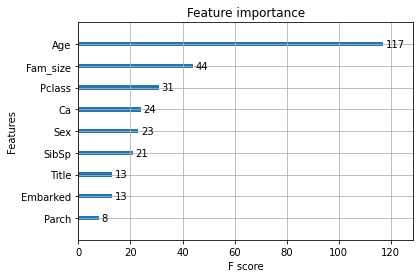

In [374]:
# 피처 중요도 확인 
from xgboost import plot_importance
plot_importance(xgb_model)

In [375]:
display(local_train.drop(drop_cols, 1).columns)
display(lg_model.coef_)

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Ca', 'Fam_size',
       'Title'],
      dtype='object')

array([[-0.92985399, -2.50080305, -0.03067915, -0.07273479, -0.02451979,
        -0.14395364, -0.04107257, -0.09725458,  0.28568184]])

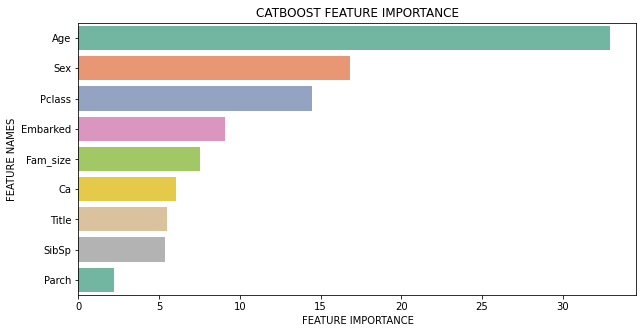

In [376]:
#Feature Importance of CatBoostClassifier

# https://www.analyseup.com/python-machine-learning/catboost-python-tutorial.html
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,5))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='Set2')
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(cat_model.get_feature_importance(),local_train.drop(drop_cols,1).columns,'CATBOOST')

## 9. test data import, preprocessing

In [377]:
drop_cols=['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare']
result =pd.DataFrame(index=range(0,len(df_all_test.drop(drop_cols,1))), columns=['lgbm', 'xgb', 'lg', 'cat'])

lgbm_pred=model.predict(df_all_test.drop(drop_cols,1))
result['lgbm']=lgbm_pred

xgb_pred=xgb_model.predict(df_all_test.drop(drop_cols,1))
result['xgb']=xgb_pred

lg_pred=lg_model.predict(df_all_test.drop(drop_cols,1))
result['lg']=dt_pred

cat_pred=cat_model.predict(df_all_test.drop(drop_cols,1))
result['cat']=cat_pred


In [378]:
result.head(4)

,lgbm,xgb,lg,cat
0,0,0,0,0
1,1,1,0,0
2,0,0,0,1
3,0,0,0,0


In [380]:
# result['final']=0.5*result['dt']+0.1*result['cat']+0.5*result['xgb']+0.1*result['lgbm']
result['final']=0.5*result['lg']+0.5*result['xgb']

In [381]:
result['final_round']=round(result['final'],0).astype(int)  #dt:0.5, xgb:0.3, cat:0.1, lgbm:0.1 (X) 

In [382]:
from IPython.display import FileLink
submission = pd.DataFrame({'PassengerId':df_all_test.PassengerId, 
              'Survived':result['final_round']})
submission.to_csv('submission.csv', index=False)
trial1=pd.read_csv('submission.csv')

In [383]:
FileLink('submission.csv')

/kaggle/working/submission.csv